## Importing all the necessary libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [3]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

--2023-01-12 17:23:21--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0.001s  

2023-01-12 17:23:21 (24.1 MB/s) - ‘helper_prabowo_ml.py’ saved [13881/13881]



In [4]:
!pip install transformers

In [5]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-01-12 17:23:43.192144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 17:23:43.193061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 17:23:43.194076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 17:23:43.194836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node z

## Loading the train, validation and test datasets

In [6]:
train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

## Combining the train, validation and test datasets into a single dataframe

In [7]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,6055,i feel suspicious but i cant walk a way i like...,fear
1,10440,i have these new songs that feel very vital an...,joy
2,8154,going to take my driving test,fear
3,1709,i started feeling bad i began taking zicam and...,sadness
4,7679,i feel like an ungrateful ingrate bastard to c...,sadness


In [8]:
df.drop('index',axis=1,inplace=True)

In [9]:
df.shape

(2000, 2)

## Text Preprocessing

In [10]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [11]:
preprocessed_df = preprocess_data(df,'Input')
preprocessed_df.head()

,Input,Sentiment
0,feel suspicious walk way always thing football...,fear
1,ew songs feel vital real ready shared,joy
2,going take driving test,fear
3,started feeling bad began taking zicam seemed ...,sadness
4,feel ungrateful ingrate bastard confess moment...,sadness


In [12]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)

In [13]:
preprocessed_df.head()

,Input,Sentiment,num_words
0,feel suspicious walk way always thing football...,fear,63
1,ew songs feel vital real ready shared,joy,37
2,going take driving test,fear,23
3,started feeling bad began taking zicam seemed ...,sadness,78
4,feel ungrateful ingrate bastard confess moment...,sadness,74


In [14]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

## Train-Test Split

In [15]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)

## Loading the Tokenizer class and pretrained BERT model

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


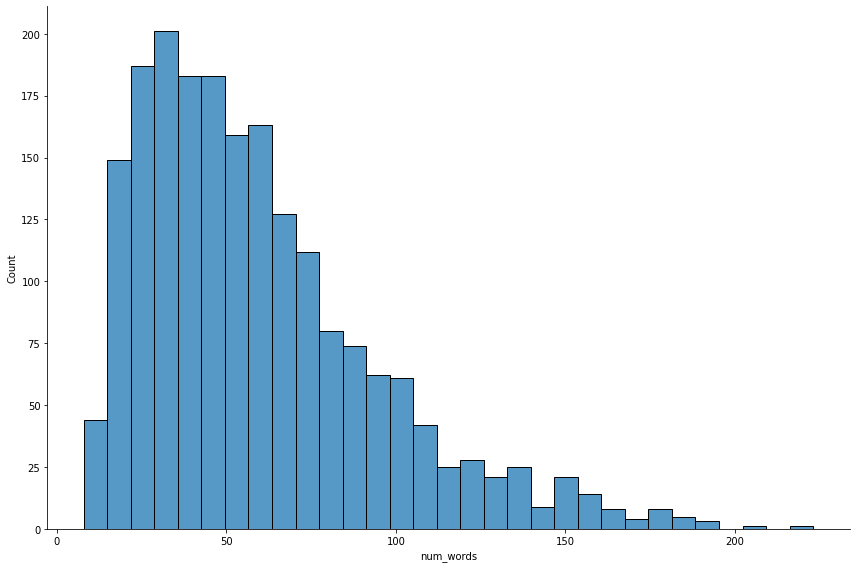

In [17]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

In [18]:
max_len = 32

## Text Tokenization

In [19]:
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [20]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [21]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

## Compiling the model

In [22]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

## Encoding the emotion labels

In [23]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [24]:
train_data.head()

,Input,Sentiment,num_words,Label
497,always feel awkward im alone crowd peers feel ...,sadness,63,4
174,still cognize disregarding feel jesus thing re...,fear,75,1
1163,thrilled outcome feeling crappy even celebrate...,sadness,157,4
183,feel really listless right,sadness,26,4
277,feel actively hated every single second rather...,anger,52,0


In [25]:
test_data.head()

,Input,Sentiment,num_words,Label
488,feel sympathetic parties involved careers dra,love,45,3
656,d really hop quickly knew theyd cry yell didnt...,sadness,88,4
761,seoul could help feel jealous,anger,29,0
1009,m feeling kinda grumpy im going post videos cheer,anger,49,0
344,feel cabbage potatoes venison components rich ...,joy,103,2


## Generating the model summary and plot

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 32)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


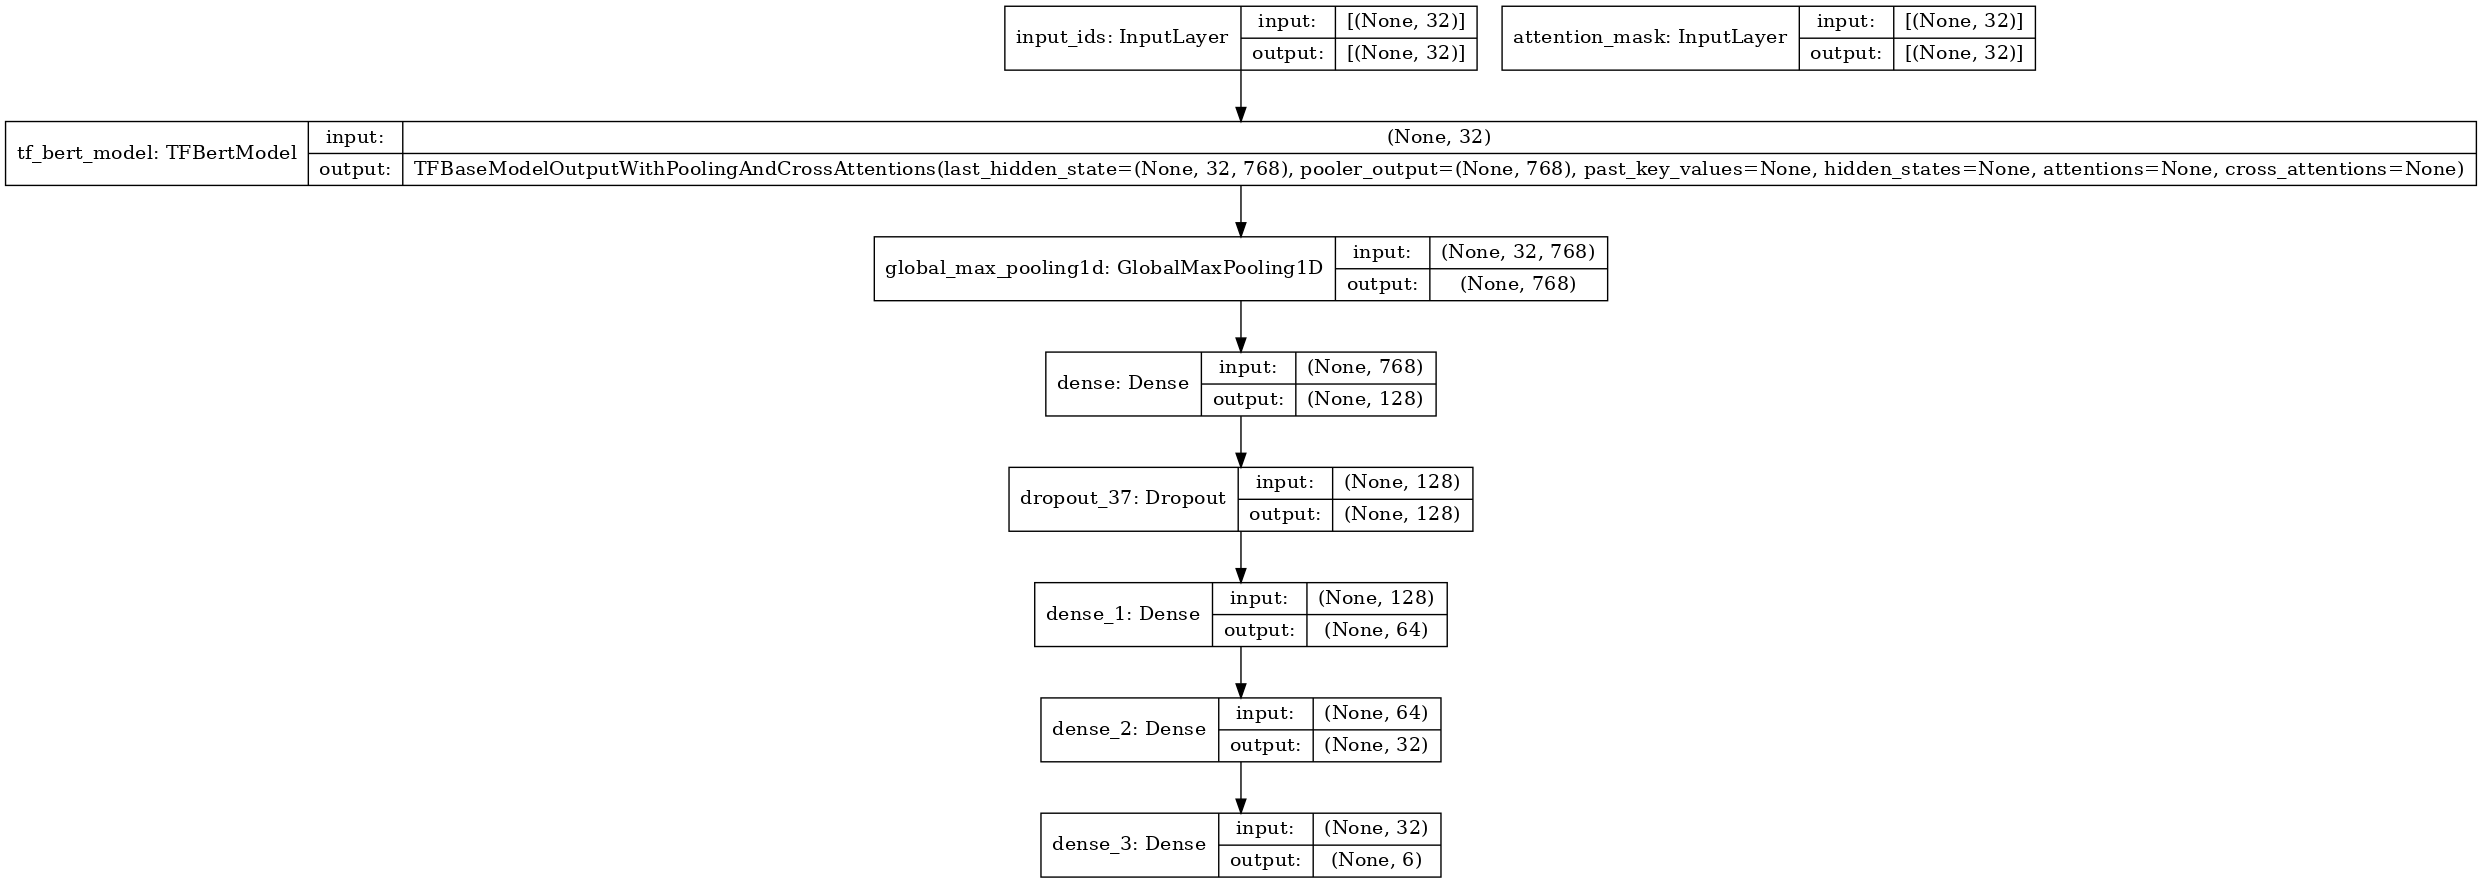

In [27]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

## Training and fine-tuning the pretrained BERT model 

In [28]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=4,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

2023-01-12 17:24:26.128852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
44/44 [==============================] - 33s 313ms/step - loss: 1.6893 - balanced_accuracy: 0.3029 - val_loss: 1.3790 - val_balanced_accuracy: 0.5517
Epoch 2/4
44/44 [==============================] - 11s 255ms/step - loss: 1.2072 - balanced_accuracy: 0.5929 - val_loss: 0.8640 - val_balanced_accuracy: 0.7317
Epoch 3/4
44/44 [==============================] - 11s 259ms/step - loss: 0.7732 - balanced_accuracy: 0.7507 - val_loss: 0.6631 - val_balanced_accuracy: 0.7800
Epoch 4/4
44/44 [==============================] - 11s 261ms/step - loss: 0.5388 - balanced_accuracy: 0.8264 - val_loss: 0.4998 - val_balanced_accuracy: 0.8317


## Analyzing model performance

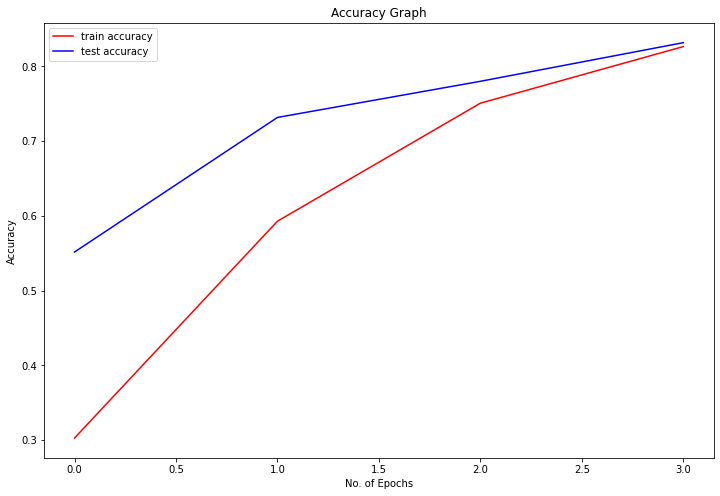

In [29]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [30]:
model.save("emotion_detector.h5")

## Evaluating the model on the test dataset

In [31]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 2s 96ms/step - loss: 0.4998 - balanced_accuracy: 0.8317
Test Categorical Cross-Entropy Loss: 0.49983078241348267
Test Categorical Accuracy: 0.8316666483879089


In [32]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84        86
           1       0.86      0.80      0.83        80
           2       0.76      0.95      0.84       192
           3       0.91      0.20      0.33        49
           4       0.89      0.97      0.93       178
           5       0.00      0.00      0.00        15

    accuracy                           0.83       600
   macro avg       0.71      0.62      0.63       600
weighted avg       0.82      0.83      0.80       600



In [33]:
X_test['input_ids']
X_test['attention_mask']

<tf.Tensor: shape=(600, 32), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [36]:
sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!",
            "Best day of my life"
            ]

'''PRED = tokenizer(text=sentences,
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )
PRED['input_ids']
PRED['attention_mask']'''

#loss, acc = model.evaluate({'input_ids': PRED['input_ids'], 'attention_mask': PRED['attention_mask']},to_categorical(test_data.Label))
#print("Test Categorical Cross-Entropy Loss:",loss)
#print("Test Categorical Accuracy:",acc)

input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(encoded_labels)
input_ids
attention_masks

encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

test_predictions = model.predict({'input_ids': input_ids, 'attention_mask': attention_masks})
test_predictions = np.argmax(test_predictions,axis=1)

rev = dict([(v, k) for k, v in encoded_labels.items()])#{v:k for k,v in encoded_labels.items()}
for p in test_predictions:
    print(rev[p])

#test_predictions = model.predict({'input_ids': PRED['input_ids'], 'attention_mask': PRED['attention_mask']})
#test_predictions = np.argmax(test_predictions,axis=1)
#test_predictions = np.argmax(test_predictions)
#test_predictions
#test_predictions = np.argmax(test_predictions,axis=1)



sadness
anger
sadness
joy
joy


The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.